# Data Preparation

In [1]:
import sklearn
import sklearn_crfsuite
import string
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn_crfsuite import metrics
from joblib import dump, load
import matplotlib.pyplot as plt

In [2]:
def read(file):
    with open(file, 'r', encoding='utf8') as f:
        file = f.read().splitlines()
    data = [[] for _ in range(len(file))]
    for idx, i in enumerate(file):
        a = i.split()
        for j in a:
            tmp = (j.rsplit('/',1))
            data[idx].append((tmp[0], tmp[1]))
    return data

In [3]:
train_set = read('../corpus/train.txt')
test_set = read('../corpus/test.txt')

In [4]:
#Features extraction for CRF model
def word2features(sent, i):
    word = sent[i][0]
#     postag = sent[i][1]
    if i == 0:
        first = True
    else:
        first = False
    if i == len(sent) - 1:
        last = True
    else:
        last = False

    features = {
        'word' : word,
        'lower': word.lower(),
        'number': word.isdigit(),
        'is_title()': word.istitle(),
        'is_upper()': word.isupper(),
        'has_hyphen': '-' in word,
        'is_first': first,
        'is_last': last
    }

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


def sent2labels(sent):
    return [word[1] for word in sent]


def sent2tokens(sent):
    return [word[0] for word in sent]

In [5]:
X_train = [sent2features(s) for s in train_set]
y_train = [sent2labels(s) for s in train_set]

X_test = [sent2features(s) for s in test_set]
y_test = [sent2labels(s) for s in test_set]

In [6]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1,
    c2=0.25,
)

In [7]:
crf.fit(X_train, y_train)

c:\users\owcap\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', c1=0.1, c2=0.25, keep_tempfiles=None)

In [8]:
#Save model for GUI use
dump(crf,'../models/crf.joblib')

['../models/crf.joblib']

In [9]:
labels = list(crf.classes_)
labels.remove('X')

In [10]:
#obtaining metrics such as accuracy, etc. on the train set
ypred = crf.predict(X_train)
print('F1 score on the train set = {}\n'.format(metrics.flat_f1_score(y_train, ypred, average='weighted', labels=labels)))
print('Accuracy on the train set = {}\n'.format(metrics.flat_accuracy_score(y_train, ypred)))

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

F1 score on the train set = 0.9669901131427421

Accuracy on the train set = 0.9668281774133433



In [11]:
#obtaining metrics such as accuracy, etc. on the test set
# print('Train set classification report: \n\n{}'.format(metrics.flat_classification_report(
# y_train, ypred, labels=sorted_labels, digits=3
# )))
#obtaining metrics such as accuracy, etc. on the test set
ypred = crf.predict(X_test)
print('F1 score on the test set = {}\n'.format(metrics.flat_f1_score(y_test, ypred,
average='weighted', labels=labels)))
print('Accuracy on the test set = {}\n'.format(metrics.flat_accuracy_score(y_test, ypred)))

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
# print('Test set classification report: \n\n{}'.format(metrics.flat_classification_report(y_test, ypred, labels=sorted_labels, digits=3)))

F1 score on the test set = 0.8511374383708683

Accuracy on the test set = 0.8564356435643564



c:\users\owcap\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


# Visualize top 15 tuples the HMM gets wrong

In [12]:
wrong = [(x,y) for i, j in zip(ypred, y_test) for x,y in zip(i, j) if x!=y]

In [13]:
from collections import Counter

wrong_tuple = dict(Counter(wrong).most_common(15))
wrong_tuple = dict(sorted(wrong_tuple.items(), key=lambda item: item[1]))

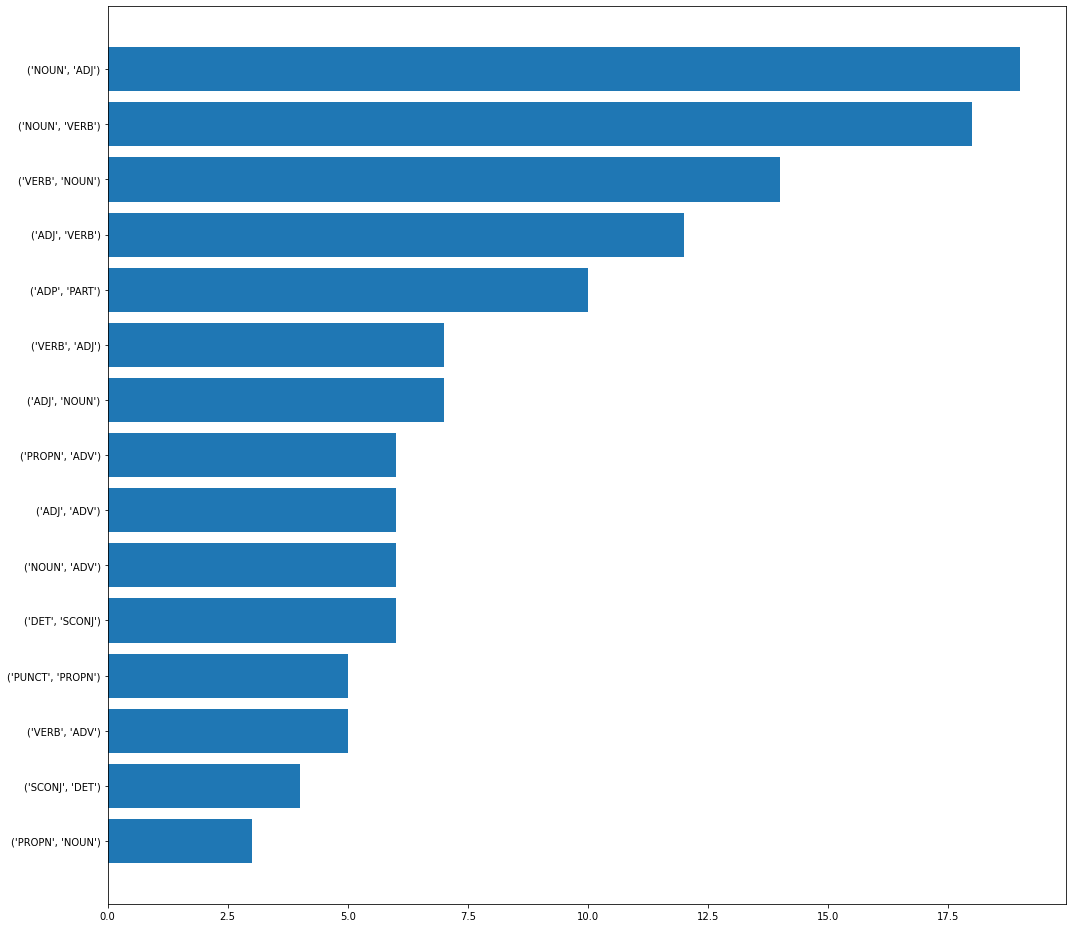

In [14]:
plt.rcParams["figure.figsize"] = (15,13)
plt.barh(range(len(wrong_tuple)), list(wrong_tuple.values()), align='center')
plt.yticks(range(len(wrong_tuple)), list(wrong_tuple.keys()))
# plt.xticks(rotation=90)
# plt.show()
plt.tight_layout()
plt.savefig('../img/wrong_tuple_crf.png', bbox_inches='tight', pad_inches=0.0)